In [1]:
# import: external libraries
import torch
import torchshow as ts
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from PIL import Image
from tqdm.notebook import tqdm

print(f"cuda: {torch.cuda.is_available()}")

# import: solutions from the lessons
from underwater_imagery.models.encoder_decoder import Encoder, Decoder, EncoderDecoder

# import: own modules
from underwater_imagery.data.uim_dataset import UIMDataset
from underwater_imagery.data.constants import TRAIN_PATH, CLASSES, SHAPE
from underwater_imagery.data.transf import resize_transf, resize_normalize_transf
print(SHAPE)

cuda: True
(240, 320)


In [2]:
sizes = []
for img_path in TRAIN_PATH.glob("./images/*.jpg"):
    img = Image.open(str(img_path.absolute()))
    arr = np.array(img)
    w, h, _ = arr.shape
    sizes.append([w, h])
print(np.unique(sizes, axis=0))

[[ 360  640]
 [ 375  590]
 [ 416  416]
 [ 435  910]
 [ 448  480]
 [ 480  584]
 [ 480  640]
 [ 540  960]
 [ 600  800]
 [ 720 1152]
 [ 720 1280]
 [ 960 1280]
 [1080 1906]]


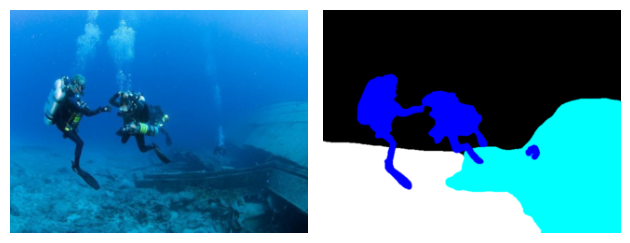

BW


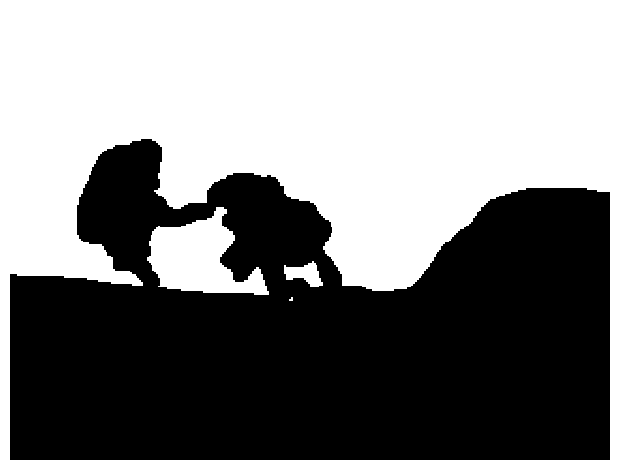

HD


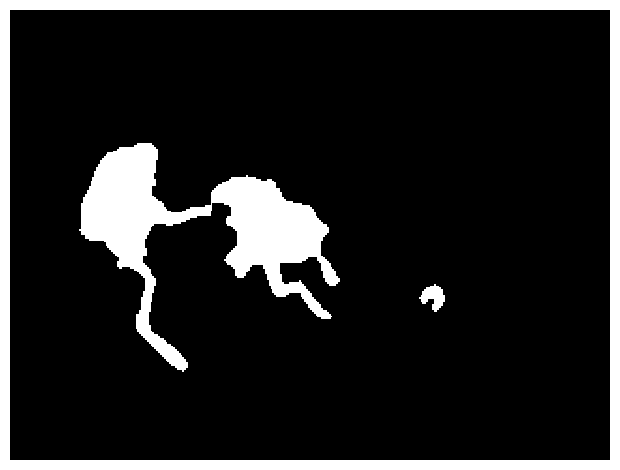

PF


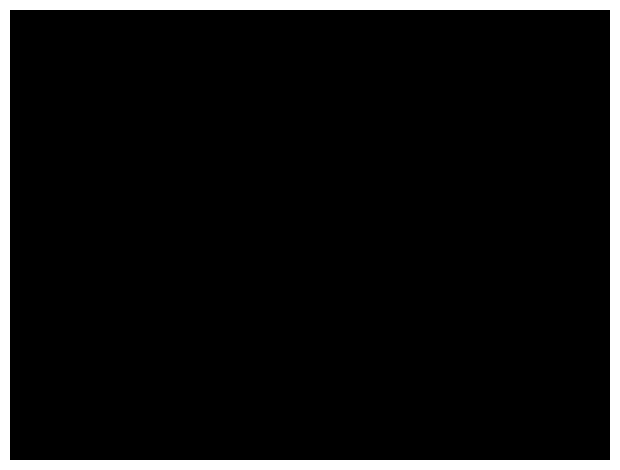

WR


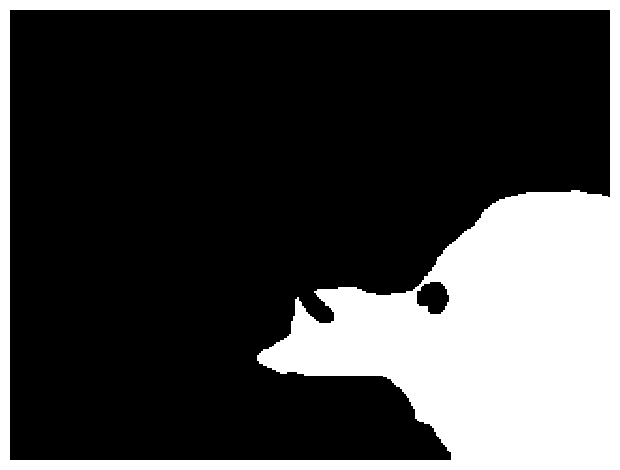

RO


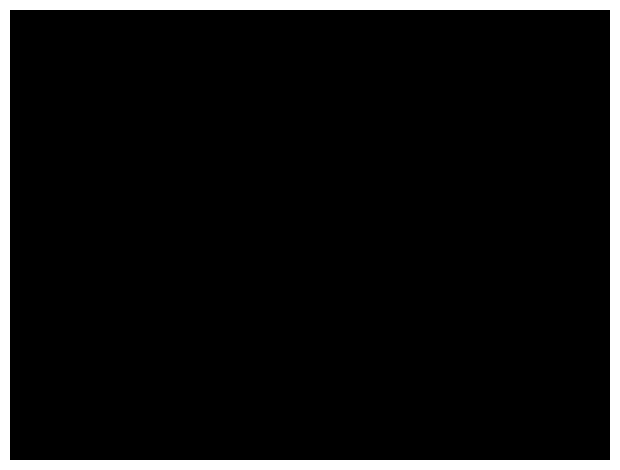

RI


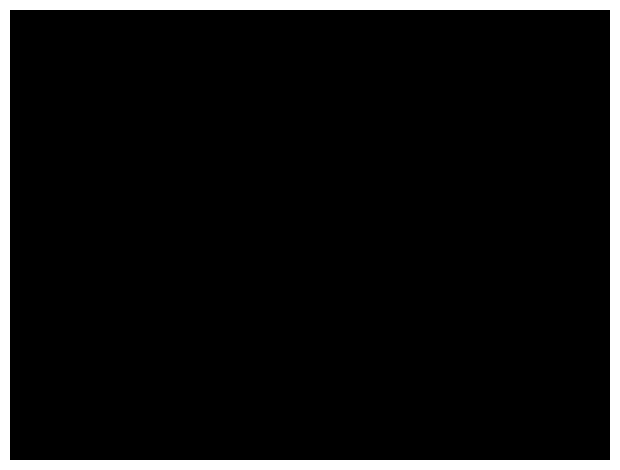

FV


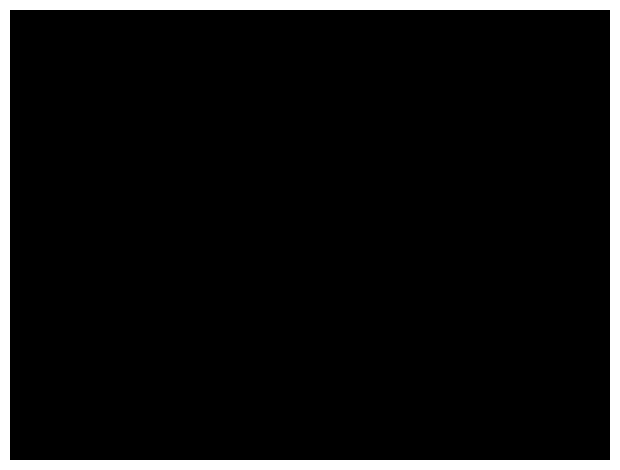

SR


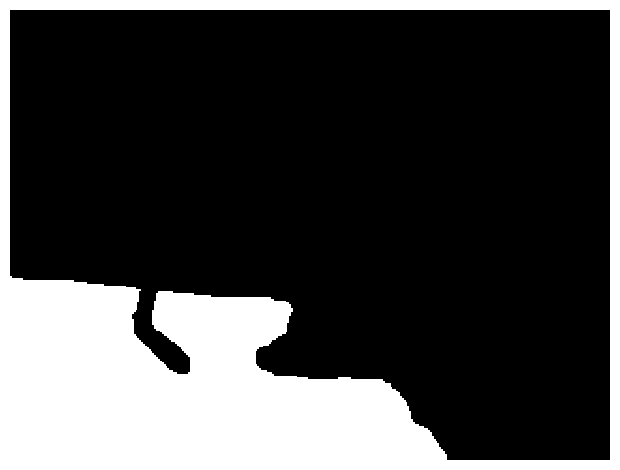

In [3]:
data = UIMDataset(
    TRAIN_PATH, 
    CLASSES, 
    SHAPE,
    resize_transf, 
    resize_transf
)

img, mask, label = data[0]
ts.show([img, label])
plt.show()

for i, cls in enumerate(data.classes):
    print(cls[0])
    ts.show(mask[i, :, :]) 
    plt.show()

In [4]:
# Überprüfen der Architektur. Pro Klasse eine Maske und Input dim == Output dim.
num_channels = [16, 32, 64]
num_classes = len(data.classes)

encoder = Encoder(num_channels)
decoder = Decoder(list(reversed(num_channels)))
encoder_decoder = EncoderDecoder(
    encoder, 
    decoder, 
    num_initial_channels=16,
    num_input_channels=16,
    num_output_channels=num_classes
)

pred = encoder_decoder(img.to('cuda'))
assert num_classes == pred.shape[0]
assert img.shape[1] == pred.shape[1]
assert img.shape[2] == pred.shape[2]

In [5]:
batch_size = 64

ds = UIMDataset(
    TRAIN_PATH, 
    CLASSES, 
    SHAPE,
    resize_normalize_transf,
    resize_transf
)

ds_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
)

In [7]:
import torch.optim as optim

torch.manual_seed(123)

# Parameters
num_epochs = 8

# create model
num_channels = [64, 128, 256, 512]
num_classes = len(ds.classes)
encoder = Encoder(num_channels)
decoder = Decoder(list(reversed(num_channels)))
encoder_decoder = EncoderDecoder(
    encoder, decoder, num_initial_channels=64, num_input_channels=64, num_output_channels=num_classes)
encoder_decoder.to('cuda')

# Create Loss-Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(encoder_decoder.parameters())

pbar = tqdm(total=num_epochs * len(ds_loader))

step = 0
for epoch in range(0, num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(ds_loader):
        images, label_masks, label_images = data
        images = images.to('cuda')
        label_masks = label_masks.to('cuda')
        label_images = label_images.to('cuda')

        # Forward-Pass
        optimizer.zero_grad()
        logits = encoder_decoder(images)
        probs = F.softmax(logits, dim=1)
    
        # Optimize
        loss = criterion(logits, label_masks)
        loss.backward()
        optimizer.step()

        # Calculate Pixel-Accuracy
        pred = probs.argmax(dim=(1), keepdim=True)
        pixel_acc = (label_images == pred).to(torch.float).mean()
        running_loss += loss.item()
        running_acc += pixel_acc
        step += 1
        print_every = 10
        if (i % print_every) == (print_every - 1):
            desc = f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_every:.3f} acc: {running_acc / print_every:.3f}'
            _ = pbar.update(print_every)
            _ = pbar.set_description(desc)
            running_loss = 0.0
            running_acc = 0.0

pbar.close()
    
print('Finished Training')

  0%|          | 0/192 [00:00<?, ?it/s]

Finished Training


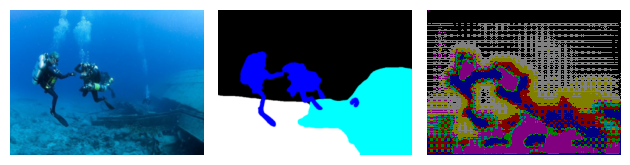

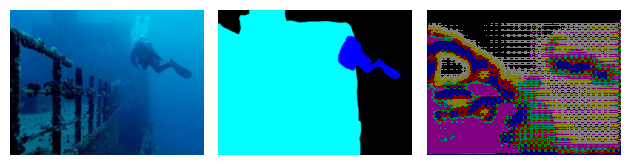

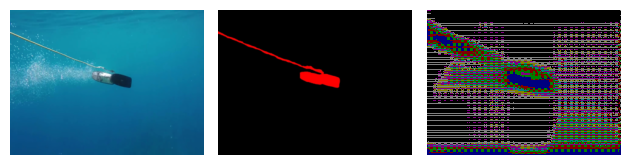

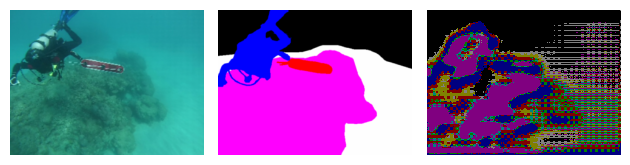

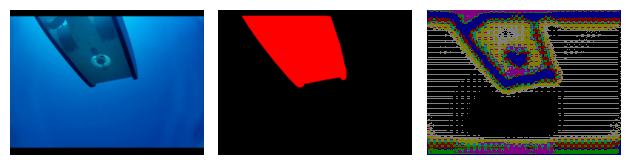

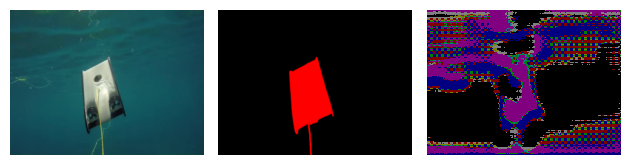

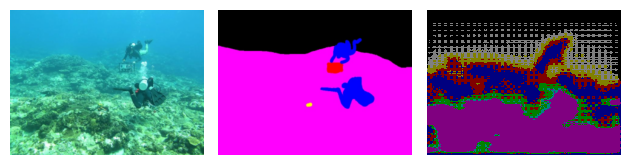

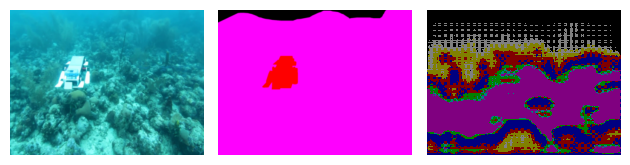

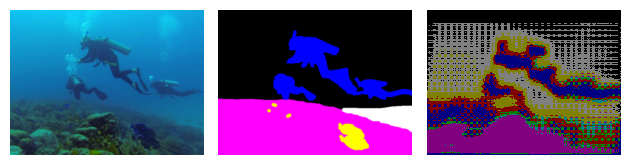

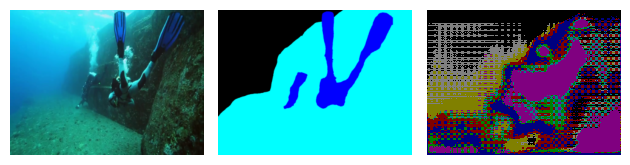

In [9]:
from underwater_imagery.data.transf import pred_to_label
for i in range(10):
    images, _, label_images = ds[i]
    logits = encoder_decoder(images.to('cuda'))
    probs = F.softmax(logits, dim=1)
    pred = probs.argmax(dim=(0), keepdim=True)
    pred_label = pred_to_label(pred)
    ts.show([images, label_images, pred])